# 📘 Example: Simple Scenario

In this notebook we demonstrate the **workflow** on how you can build a simple **FloodAdapt scenario** in Charleston, USA, using the **API**.  

In this notebook we will cover the following steps:

1. Create a synthetic **event** 
2. Create a **projection** - Sea level rise (SLR)
3. Create a **measure** and **strategy** - Seawall
4. Create and run a **scenario**
6. Investigate the **output**


## Import libraries

In [ ]:
# Import packages
#import contextily as cx
from datetime import datetime
import geopandas as gpd
from pathlib import Path
import rasterio
import rasterio.plot
from IPython.display import HTML

import flood_adapt.objects.forcing as f
import flood_adapt.objects.measures as m
from flood_adapt.objects import TimeFrame
from flood_adapt.config.sfincs import RiverModel
from flood_adapt.dbs_classes.database import Database
from flood_adapt.objects.events.synthetic import SyntheticEvent 
from flood_adapt.flood_adapt import FloodAdapt

from flood_adapt.objects.projections.projections import Projection, PhysicalProjection, SocioEconomicChange
from flood_adapt.objects.scenarios.scenarios import Scenario
from flood_adapt import Settings
from flood_adapt.objects.strategies.strategies import Strategy
from flood_adapt import unit_system as us

## 🚀 **Step 1**. Reading-in the FloodAdapt database

Let's start with initiating the database and FloodAdapt class. 
1. Initiate the database class [`Settings`](../../api_ref/Settings.qmd) by defining the `DATABASE_ROOT` and `DATABASE_NAME`.
2. Initiate the [`FloodAdapt`](../../api_ref/FloodAdapt.qmd) class by parsing the `Settings().database_path`.

In [2]:
# Define the static data folder
STATIC_DATA_DIR = Path("../../_data/examples/static-data/3_Measures").resolve()

# Set up the settings for the database
Settings(
    DATABASE_ROOT=Path("../../_data/examples").resolve(),
    DATABASE_NAME="charleston_test"
)

# Create the FloodAdapt instance
fa = FloodAdapt(Settings().database_path)

Attempt 1/5 failed to delete C:\Users\rautenba\repos\FloodAdapt\docs\_data\examples\charleston_test\output\scenarios\slr_pop_growth_seawall_water_square_elev_floodproof_build\Flooding\simulations\overland\sfincs_his.nc: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\rautenba\\repos\\FloodAdapt\\docs\\_data\\examples\\charleston_test\\output\\scenarios\\slr_pop_growth_seawall_water_square_elev_floodproof_build\\Flooding\\simulations\\overland\\sfincs_his.nc'
Attempt 2/5 failed to delete C:\Users\rautenba\repos\FloodAdapt\docs\_data\examples\charleston_test\output\scenarios\slr_pop_growth_seawall_water_square_elev_floodproof_build\Flooding\simulations\overland\sfincs_his.nc: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\rautenba\\repos\\FloodAdapt\\docs\\_data\\examples\\charleston_test\\output\\scenarios\\slr_pop_growth_seawall_water_square_elev_floodproof_build\\Floodi

## 🌊 **Step 2**. Events - Create a synthetic Event

Events in FloodAdapt are categorized into different forcings:
1. **Wind**
2. **Rainfall**
3. **Discharge**
4. **Water Level**

If you want to learn more about the individual forcings in FloodAdapt, please go and read the section on [**Events**](../../4_user_guide/events/index.qmd) in the FloodAdapt documentation.

When creating an event, we need to create an [`Event`](../../api_ref/Event.qmd) object. Depending on which type of event we create, we select a different class. In this example we create a **synthetic event**, therefore we use the [`SyntheticEvent`](../../api_ref/objects/SyntheticEvent.qmd) class. 

To create the `SyntheticEvent` object we use the `time` attribute to define the event duration. This should be parsed as a [`TimeFrame`](../../api_ref/TimeFrame.qmd) object. In the [`forcings`](../../api_ref/IForcing.qmd) attribute we aggregated the different forcing objects in a dictionary.  

In this event example we will create an event with the following `forcings`:  
🌬️ `WindConstant`: Define a value for a constant wind speed (mps) and direction (degrees)  
🌧️ `RainfallConstant`: Define a value for a constant rainfall (mm/hr)  
💦 `DischargeConstant`: Define the x and y coordinates of the discharge point of the Cooper River and a value for a constant mean discharge (cfs) in the River- and Discharge model (same value)  
🌊 `WaterlevelSynthetic SurgeModel`: Define a peak time (h), peak value in (m) and duration (d)  
↔️ `WaterlevelSynthetic TideModel`: Define the harmonic amplitude (m), harmonic period (h) and harmonic phase (h)  

For a complete guide on all the possible event options and inputs check out the [**notebook**](../events/index.qmd) specifically on **events**.  

In [3]:
# Create a synthetic event object
attrs_event = SyntheticEvent(
        name="synthetic_nearshore",
        description = "This is a synthetic nearshore event",
        time=TimeFrame(
            start_time=datetime(2020, 1, 1),
            end_time=datetime(2020, 1, 2),
        ),
        forcings={
            f.forcing.ForcingType.WIND: [
                f.wind.WindConstant(
                    speed=us.UnitfulVelocity(value=5, units=us.UnitTypesVelocity.mps),
                    direction=us.UnitfulDirection(
                        value=60, units=us.UnitTypesDirection.degrees
                    ),
                )
            ],
            f.forcing.ForcingType.RAINFALL: [
                f.rainfall.RainfallConstant(
                    intensity=us.UnitfulIntensity(
                        value=20, units=us.UnitTypesIntensity.mm_hr
                    )
                )
            ],
            f.forcing.ForcingType.DISCHARGE: [
                f.discharge.DischargeConstant(
                    river=RiverModel(
                        name="cooper",
                        description="Cooper River",
                        x_coordinate=595546.3,
                        y_coordinate=3675590.6,
                        mean_discharge=us.UnitfulDischarge(
                            value=5000, units=us.UnitTypesDischarge.cfs
                        ),
                    ),
                    discharge=us.UnitfulDischarge(
                        value=5000, units=us.UnitTypesDischarge.cfs
                    ),
                )
            ],
            f.forcing.ForcingType.WATERLEVEL: [
                f.waterlevels.WaterlevelSynthetic(
                    surge=f.waterlevels.SurgeModel(
                        timeseries=f.timeseries.TimeseriesFactory.from_args(
                            shape_type=f.timeseries.ShapeType.triangle,
                            duration=us.UnitfulTime(
                                value=1, units=us.UnitTypesTime.days
                            ),
                            peak_time=us.UnitfulTime(
                                value=8, units=us.UnitTypesTime.hours
                            ),
                            peak_value=us.UnitfulLength(
                                value=1, units=us.UnitTypesLength.meters
                            ),
                        )
                    ),
                    tide=f.waterlevels.TideModel(
                        harmonic_amplitude=us.UnitfulLength(
                            value=1, units=us.UnitTypesLength.meters
                        ),
                        harmonic_period=us.UnitfulTime(
                            value=12.4, units=us.UnitTypesTime.hours
                        ),
                        harmonic_phase=us.UnitfulTime(
                            value=0, units=us.UnitTypesTime.hours
                        ),
                    ),
                )
            ],
        },
    )

### 💾 **Step 2.1**. Saving the event to the database

In [4]:
# Save the event to the database
fa.save_event(attrs_event)

## 📈 **Step 3**. Projections - Create a projection

**Projections** in FloodAdapt allow us to adjust our model to future conditions such as sea level rise or/and population growth. If you want to learn more about projections in FlooAdapt, please go to the section [Projections](../../4_user_guide/projections/index.qmd) in the FloodAdapt documentation. 
  
The projections can be divided into two categories:
1. 🌊 **Physical Projections**: Sea level rise, intensified precipitation, increased storm frequency
2. 💰 **Socio economic change**: Population growth (existing built area, new development area), economic growth

When creating a projection we need to create a [`Projection`](../../api_ref/Projection.qmd) object. The `PhysicalProjection` attribute is parsed as a [`PhysicalProjection`](../../api_ref/PhysicalProjection.qmd) object which captures the pysical projection such as sea lvel rise. The `SocioEconomicChange` attribute is parsed as a [`SocioEconomicChange`](../../api_ref/SocioEconomicChange.qmd) object which captures the socioeconomic projection such as population growth. It's not mandatory to parse both projections. If we only want to use one of the two types of projections we can leave the other one blank (). 

The attributes of the `PhysicalProjection` or `SocioEconomicChange` object define the projection. In this case we parse the attribute `sea_level_rise` to the `PhysicalProjection` object and define the value in [`UnitfulLength`](../../api_ref/UnitfulLength.qmd) and the unit in [`UnitTypesLength`](../../api_ref/UnitTypesLength.qmd).

To get a deeper understanding for all the possible projections and their inputs go to the [**notebook**](../projections/index.qmd) specifically about **projections**.


In [5]:
# Create a projection object
attrs_projection = Projection(
    name="SLR_2ft",
    description = "This is a 2ft SLR projection",
    physical_projection=PhysicalProjection(
        sea_level_rise=us.UnitfulLength(value=2, units=us.UnitTypesLength.feet),
    ),
    socio_economic_change=SocioEconomicChange(),
)

### 💾 **Step 3.1**. Saving the projection to the database

In [6]:
# Save the projection
fa.save_projection(attrs_projection)

## 🧱 **Step 4**. Measures - Create a measure

**Measures** in FloodAdapt enable the user to mititgate the event impacts and investigate their efficiency on the fly.

Measures can be:
1. 💦 **Hydraulic** measures on the hazard level
2. 🌱 **Green infrastructure** measures on the hazard level
3. 🏠 **Impact** measures on the building level.

You can read more about measures in the section [Measures](../../4_user_guide/measures/index.qmd) in the FloodAdapt documentation. 

💦 In this example we will create a **hydraulic measure**, a sea wall of 12ft. To create a measure we need to create a [`Measure`](../../api_ref/Measure.qmd) object. 
In the attributes we define the measure `type` object, in this example a [`FloodWall`](../../api_ref/objectS/FloodWall.qmd) object. Additionally to the other attributes, we need to parse the `elevation` value as [`UnitfulLength`](../../api_ref/UnitfulLength.qmd) and the unit as [`UnitTypesLength`](../../api_ref/UnitTypesLength.qmd) of the sea wall.

In [7]:
# Create a measure object
attrs_measure_phy = m.measures.FloodWall(
        name= "Seawall_12ft",
        description = "12ft Seawall",
        type = m.measures.MeasureType.floodwall,
        selection_type = m.measures.SelectionType.polyline,
        polygon_file = str(Path(STATIC_DATA_DIR / "seawall.geojson")),
        elevation = us.UnitfulLength(value=12, units=us.UnitTypesLength.feet))

🏠 Let's add another measure on the **impact level**. We can elevate buildings in a specific area to mititgate the impact on these assets.

When elevating buildings as measure we need to create a [`Elevate`](../../api_ref/objectS/Elevate.qmd) object. we can also specify which building types we wan the measure to be applied to by defining the `property type` attribute. e can parse the building type (residential, commercial...) that is used in our Delft-FIAT Model. In this example we want to elevate all buildings so we parse `ALL`.  

To define the `elevation` we need to parse a [`UnitfulLengthRefValue`]() object which consists of a `value` of type float, a `unit` which can be one of the [`UnitTypesLength`](../../api_ref/UnitTypesLength.qmd) and a vertical reference from which point the elevation should be calculated. This sholud be parsed as [`VerticalReference`]() object.

In [8]:
# Create a measure object
attrs_measure_elev = m.measures.Elevate(
        name= "Elevated_homes",
        description = "Elevate residential buildings",
        type = m.measures.MeasureType.elevate_properties,
        selection_type = m.measures.SelectionType.polygon,
        polygon_file = str(Path(STATIC_DATA_DIR / "raise_property_polygon.geojson")),
        property_type = "ALL",
        elevation = us.UnitfulLengthRefValue(value=1, units=us.UnitTypesLength.feet, type = us.VerticalReference.floodmap))

### 💾 **Step 4.1**. Saving the measure to the database

In [9]:
# Save the measure
fa.save_measure(attrs_measure_phy)
fa.save_measure(attrs_measure_elev)

## 🧩 **Step 5**. Strategies - Create a strategy

**Strategies** are combinations **measures**. They allow us to run an test multiple measures in a single model run. 

To create a strategy we need to create a [`Strategy`](../../api_ref/Strategy.qmd) object. In the `measures` attribute we parse a list of all the names of the measures that we want to apply in that strategy.

In [10]:
# Create a strategy object
attrs_strategy = Strategy(
        name= "seawall_and_elev_build",
        description = "Strategy with a seawall and elevation of buildings",
        measures = [attrs_measure_phy.name, attrs_measure_elev.name],
        )

### 💾 **Step 5.1**. Saving the strategy to the database

In [11]:
# Save the stategy
fa.save_strategy(attrs_strategy )

## 🗺️ **Step 6**. Create a scenario

We reached the final step where we can put all the building blocks together to create a complete scenario!  
A scenario is composed of:

**1. Event**  
**2. Projection**  
**3. Strategy (Measures)**

If you want to read more about the composition of scenarios, go read the [**Scenario**](https://deltares-research.github.io/FloodAdapt/4_user_guide/scenarios/)-section of the FloodAdapt documentation. 

When creating a scenario we need to create a [`Scenario`](../../api_ref/Scenario.qmd) object in which we parse the name of the `event`, `projection` and `strategy` as attributes.

In [12]:
# Create a scenario object
scenario = Scenario(
    name = "slr_nearshore_seawall_elev_build",
    description = "Nearshore event with SLR projection and seawall + elevated buildings strategy",
    event =  attrs_event.name,
    projection =  attrs_projection.name,
    strategy = attrs_strategy.name,
)

### 💾 **Step 6.1**. Saving the scenario to the database

In [13]:
# Save the scenario
fa.save_scenario(scenario)

(True, '')

## 🏃‍♀️ **Final step**: Run a scenario

We are ready to **run** the scenario! Simply parse the `scenario.name` into the function `run_scenario`.

In [14]:
# Run the scenario
fa.run_scenario(scenario.name)

2025-05-27 10:25:13 AM - FloodAdapt.SfincsAdapter - WARNING - Failed to add event rainfall multiplier, no rainfall forcing found in the model.
2025-05-27 10:25:15 AM - FloodAdapt.SfincsAdapter - WARNING - Could not use height data from file due to missing `z` column or missing values therein. Using uniform height of 12.0 feet instead.


## **Finished!** 
**Congratulations** you created and ran your first FloodAdapt scenario!

## **Output**: 🕵️‍♀️ Let's inspect the output

#### **1. Output files**
In your scenario output folder you should see the following files:
- **Flooding**: Folder
- **Impacts**: Folder
- **finished.txt**: text file
- **Infometrics_"*scenario_name*".csv**: csv file of the overall infometrics
- **Infometrics_"*scenario_name*"_"*aggregation_layer*".csv**: csv file  of the aggregated areas. You have one file per aggregation level. In this example we have two files. 
- **logfile_"*scenario_name*".log**: The log of the scenario run
- **"*scenario_name*"_metrics.html**: A metric file of your scenario output

The figure below presents a visual overview of all the output files that should be in your database after running the scenario
<div>
<img src="../_static/images/output_folder_event.png" width="500"/>
</div>

#### **2. Floodmap** - Inspect the floodmap

We can open and inspect the floodmap geotiff.

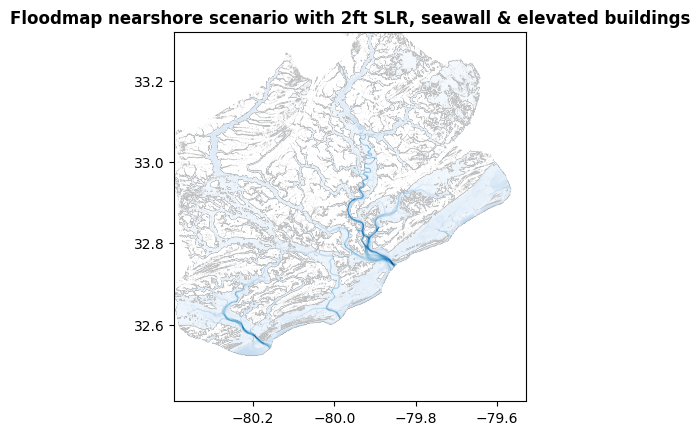

<Axes: title={'center': 'Floodmap nearshore scenario with 2ft SLR, seawall & elevated buildings'}>

In [16]:
root = Path("../../_data/examples/charleston_test").resolve()

# Open floodmap geotiff
data_name = root / "output"/ "scenarios" / "slr_nearshore_seawall_elev_build" / "Flooding" / "FloodMap_slr_nearshore_seawall_elev_build.tif"
tiff = rasterio.open(data_name)

# Plot floodmap
rasterio.plot.show(tiff, title = "Floodmap nearshore scenario with 2ft SLR, seawall & elevated buildings", cmap="Blues")

#### **3. Economic Impacts** - Inspect the economic impacts on the building level and aggregated

We can plot the economic impacts on the building level and on the aggregated level.

NameError: name 'cx' is not defined

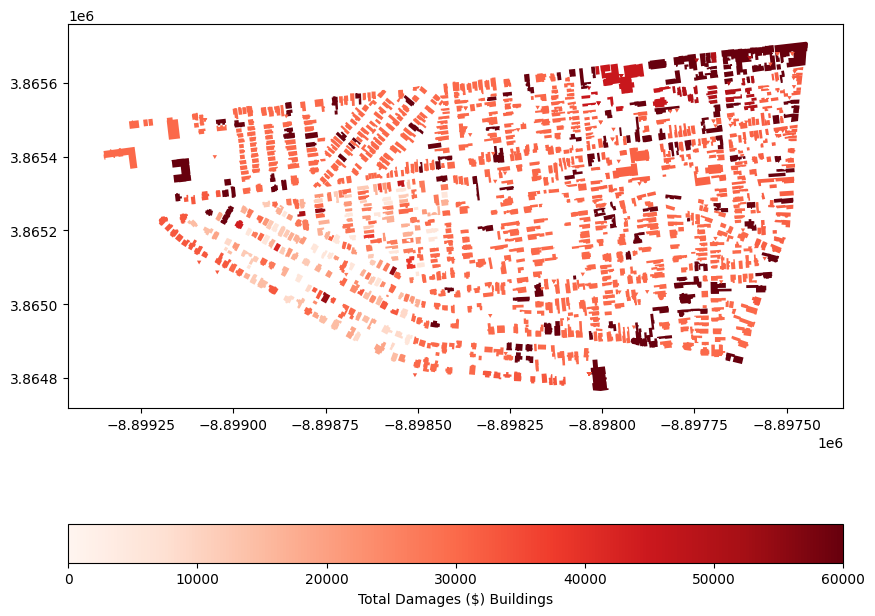

In [17]:
## Building Impacts
# Open building impacts
gdf_impacts_buildings = gpd.read_file(root / "output" / "scenarios" / "slr_nearshore_seawall_elev_build" / "Impacts" / "Impacts_building_footprints_slr_nearshore_seawall_elev_build.gpkg")

# Reproject buildings crs to Web Mercator
gdf_impacts_buildings =gdf_impacts_buildings.to_crs(epsg=3857)

# Plot building impacts
ax = gdf_impacts_buildings.plot(figsize=(10, 10),column = "Total Damage",cmap="Reds", legend = True, vmin= 0, vmax= 60000, legend_kwds={"label": "Total Damages ($) Buildings","orientation": "horizontal"})
cx.add_basemap(ax)
ax.plot()

## Aggregated Impacts
# Open aggregated impacts
gdf_impacts_aggr = gpd.read_file(root / "output" / "scenarios" / "slr_nearshore_seawall_elev_build" / "Impacts" / "Impacts_aggregated_slr_nearshore_seawall_elev_build_aggr_lvl_2.gpkg")

# Reproject buildings crs to Web Mercator
gdf_impacts_aggr = gdf_impacts_aggr.to_crs(epsg=3857)
# Plot aggregated impacts
ax = gdf_impacts_aggr.plot(figsize=(10, 10),column = "TotalDamageEvent",cmap="Reds", legend = True, vmin= 0, vmax= 10000000, edgecolor="k", legend_kwds={"label": "Total Damages ($) per aggregatetion area", "orientation": "horizontal"})
cx.add_basemap(ax)
ax.plot()

#### **4. Infometrics & Infographics**
Which **infometrics** and **infographics** to generate can be defined in the infometrics and infographics and configuration file in your database */Database/charleston_full/static/templates/infometrics/""*, */Database/charleston_full/static/templates/infographics/"".toml*, respectively.

In [ ]:
# Display HTML infographics
fn = (root / "output" / "scenarios" / "slr_nearshore_seawall_elev_build" / "Impacts_building_footprints_slr_nearshore_seawall_elev_build.html")
HTML(filename="profiling/z2pDecisionTreeProfiling.html")